In [1]:
import numpy as np
import cycler
import matplotlib.pyplot as plt
import distance as dis
import summary_statistics as sumstats
import pandas as pd
import seaborn as sns
import os
import allel
from matplotlib_venn import venn2
import msprime
import math

In [303]:
sampleSize = 32

In [37]:
os.makedirs("/home/mathieu/local/simu", exist_ok=True)
for i in range(sampleSize):
    ts = msprime.simulate(sample_size=20, Ne=140000, recombination_rate=1.53e-9, mutation_rate=1.53e-9, length=2e6)
    snp = ts.genotype_matrix().T
    pos = ts.tables.asdict()["sites"]["position"].astype(int)
    np.savez_compressed(
        f"/home/mathieu/local/simu/modA_1_{i}.npz", SNP=snp, POS=pos)

In [ ]:
%%bash
rm -rf /home/mathieu/local/toto/postgarga
cd /home/mathieu/local
mkdir /home/mathieu/local/toto/postgarga -p
for npz in toto/simu/*.npz
do
    f="$(basename -- $npz)"
    i=$(echo $f | cut -c8- | cut -d. -f1)
    #echo $i
    ./pipeline.sh -a -c 5 -l 2000000 -f $npz
    mv /home/mathieu/local/data_post_gargammel.npz /home/mathieu/local/toto/postgarga/modB_1_$i.npz
done

In [237]:
def compute_fst(fullGargaMatrix, fullSimulationMatrix):
    #fst tot
    gar = fullGargaMatrix.T
    sim = fullSimulationMatrix.T

    g = allel.model.ndarray.HaplotypeArray(gar)
    s = allel.model.ndarray.HaplotypeArray(sim)
    ac1 = g.count_alleles()
    ac2 = s.count_alleles()

    num, den = allel.hudson_fst(ac1, ac2)
    return np.sum(num) / np.sum(den)

In [326]:
def statPostgarga(simuDir, gagaDir):

    length = 2000000
    nbdifTot = 0
    nberTot = 0
    nbsingTotsimu = 0
    nbsingTotgarga = 0
    difMatrix = []
    errMatrix = []

    totgargapos = set()
    totsimupos = set()
    fsttot = 0
    
    simuFiles = os.listdir(simuDir)
    for simuFileName in simuFiles:
        #simuFile = simuDir + "/modA_1_" + str(i) + ".npz"
        simuFile = simuDir + "/" + simuFileName
        gargaName = simuFileName.replace("A", "B")
        gargaFile = gagaDir + "/" + gargaName

        simudata = np.load(simuFile)
        SimulationMatrix = simudata["SNP"]
        Simulationpos = simudata["POS"]

        # print(Simulationpos)
        gargadata = np.load(gargaFile)
        gargaMatrix = gargadata["SNP"]
        gargaPos = gargadata["POS"]

        totgargapos.update(gargaPos)
        totsimupos.update(Simulationpos)

        nbdif, nber, tabdif, taber, fullSimulationMatrix, fullGargaMatrix = dis.distance(
            SimulationMatrix, gargaMatrix, Simulationpos, gargaPos, length)

        fsttot += compute_fst(fullGargaMatrix, fullSimulationMatrix)
        
        errMatrix += taber
        difMatrix += tabdif

        nbsingSimu = dis.singleton_number(SimulationMatrix)
        nbsingGarga = dis.singleton_number(gargaMatrix)

        nbdifTot += nbdif
        nberTot += nber
        nbsingTotgarga += nbsingGarga
        nbsingTotsimu += nbsingSimu

    nbsingGargaMean = nbsingTotgarga / sampleSize
    nbsingSimuMean = nbsingTotsimu / sampleSize
    nbdifMean = nbdifTot / sampleSize
    nberMean = nberTot / sampleSize
    fstMean = fsttot/ sampleSize

    print("fst : " + str(fstMean))
    print("nbdif mean : " + str(nbdifMean))
    print("nber mean : " + str(nberMean))
    print("nbsing simu mean : " + str(nbsingSimuMean))
    print("nbsing Garga mean : " + str(nbsingGargaMean))
    #print(str(nbdifMean) + " " + str(nberMean) + " " + str(nbsingGargaMean))

    return totgargapos, totsimupos, difMatrix, errMatrix, nbsingGargaMean, nbsingSimuMean, nbdifMean, nberMean, fstMean

In [239]:
def print_distribution(difMatrix, errMatrix):
    dif = pd.DataFrame(difMatrix, columns= ["pos"])
    err = pd.DataFrame(errMatrix, columns= ["pos"])
    #pd.concat([dif,err])
    tot = pd.concat([dif, err], keys=['differences', 'missing values'], names=['keys', 'RowID'])
    tot.reset_index(inplace=True)
    sns.catplot(data=tot, x = "keys",y='pos',cut = 0, kind="violin", scale = "count")
    plt.show()

In [240]:
def print_venn(totsimupos, totgargapos, axs):
    #venn diagram
    venn2([totsimupos, totgargapos], ("simu  ", "  garga"), ax = axs)
    #axs[axnumber,3].plot()  

In [241]:
#sfs
def compute_sfs(datapath, length, name):
    # sfs simu
    sumstats.do_sum_stats(datapath, name, size_chr=length)

def print_normalized_sfs(sfspath, ax):
    sfs = pd.read_table(sfspath)
    ax.plot(sfs.freq_indiv, sfs.i_xi_norm)
    ax.fill_between(sfs.freq_indiv, sfs.i_xi_norm+sfs.i_xi_sem_norm,
                     sfs.i_xi_norm-sfs.i_xi_sem_norm, alpha=0.5)
    ax.axhline(1, linestyle="--", color="k")
    
def print_sfs(sfspath, ax):
    sfs = pd.read_table(sfspath)
    ax.plot(sfs.freq_indiv, sfs.i_xi)
    ax.axhline(1713, linestyle="--", color="k")

In [361]:
#LD
def plot_fill(x, y, yerr, color, ax=None, label=None, alpha=0.2, **kwargs):
    """x and y are series or numpy arrays"""
    if ax == None:
        fig, ax = plt.subplots(1, 1)

    ax.plot(x, y, color=color, label=label, **kwargs)
    ax.fill_between(x, y + yerr, y - yerr, color=color, lw=0, alpha=alpha)
    ax.set_xscale('log')

def plot_LD(ldpath, ax):
    ld = pd.read_table(ldpath)
    plot_fill(ld.mean_dist, ld.mean_r2, ld.sem_r2, "r", ax)

In [364]:
#initialise summary plot
fig, axs = plt.subplots(8,4 , figsize=(15, 25))
plt.close()

sumstatDir = "/home/mathieu/local/2e6/sumstats"

In [365]:
#Simulation
simuDir = "/home/mathieu/local/2e6/simu"
compute_sfs(simuDir, 2e6, "simu")
sfspath = sumstatDir +"/simu.sfs"
ldpath = sumstatDir + "/simu.ld"

In [366]:
y = 0
axs.flat[y].set(ylabel='simulation')
plot_LD(ldpath,axs[y,0])
print_normalized_sfs(sfspath,axs[y,1])
print_sfs(sfspath,axs[y,2])

fst : -0.04696498104820328
nbdif mean : 1472.59375
nber mean : 0.15625
nbsing simu mean : 1739.34375
nbsing Garga mean : 1685.9375


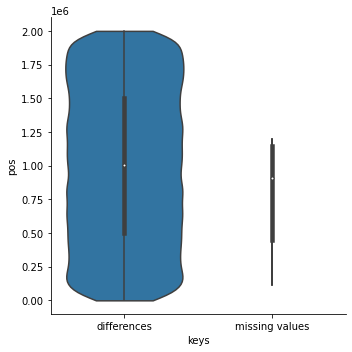

In [367]:
#C 5
gargaDir = "/home/mathieu/local/2e6/C5"
(totgargapos, totsimupos, difMatrix, errMatrix, nbsingGargaMean, nbsingSimuMean, 
nbdifMean,nberMean, fstMean) = statPostgarga(simuDir, gargaDir)

compute_sfs(gargaDir, 2e6, "C5")
sfspath = sumstatDir + "/C5.sfs"
ldpath = sumstatDir +"/C5.ld"
print_distribution(difMatrix, errMatrix)

In [368]:
y = 1
axs.flat[y*4].set(ylabel='C = 5')
plot_LD(ldpath,axs[y,0])
print_normalized_sfs(sfspath,axs[y,1])
print_sfs(sfspath,axs[y,2])
print_venn(totsimupos, totgargapos,axs[y][3])

fst : 0.05267218653481289
nbdif mean : 13266.65625
nber mean : 1.0
nbsing simu mean : 1739.34375
nbsing Garga mean : 1657.0625


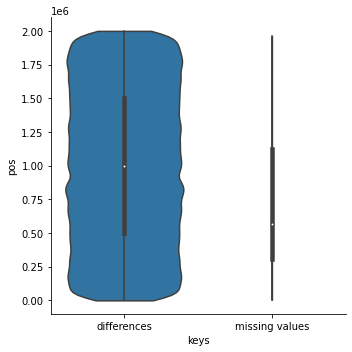

In [369]:
#C 2
gargaDir = "/home/mathieu/local/2e6/C2"
(totgargapos, totsimupos, difMatrix, errMatrix, nbsingGargaMean, nbsingSimuMean, 
 nbdifMean,nberMean, fstMean) = statPostgarga(simuDir, gargaDir)

compute_sfs(gargaDir, 2e6, "C2")
sfspath = sumstatDir + "/C2.sfs"
ldpath = sumstatDir + "/C2.ld"
print_distribution(difMatrix, errMatrix)

In [370]:
y = 2
axs.flat[y*4].set(ylabel='C = 2')
plot_LD(ldpath,axs[y,0])
print_normalized_sfs(sfspath,axs[y,1])
print_sfs(sfspath,axs[y,2])
print_venn(totsimupos, totgargapos,axs[y][3])

fst : 0.24175462901162437
nbdif mean : 23448.4375
nber mean : 0.84375
nbsing simu mean : 1739.34375
nbsing Garga mean : 1647.1875


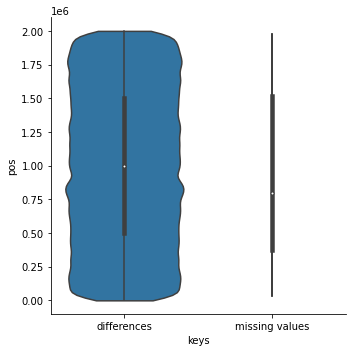

In [371]:
#C 1
gargaDir = "/home/mathieu/local/2e6/C1"
(totgargapos, totsimupos, difMatrix, errMatrix, nbsingGargaMean, nbsingSimuMean, 
 nbdifMean,nberMean, fstMean) = statPostgarga(simuDir, gargaDir)

compute_sfs(gargaDir, 2e6, "C1")
sfspath = sumstatDir + "/C1.sfs"
ldpath = sumstatDir + "/C1.ld"
print_distribution(difMatrix, errMatrix)

In [372]:
y = 3
axs.flat[y*4].set(ylabel='C = 1')
plot_LD(ldpath,axs[y,0])
print_normalized_sfs(sfspath,axs[y,1])
print_sfs(sfspath,axs[y,2])
print_venn(totsimupos, totgargapos,axs[y][3])

In [373]:
#C 0.5 
gargaDir = "/home/mathieu/local/2e6/C0_5"
(totgargapos, totsimupos, difMatrix, errMatrix, nbsingGargaMean, 
nbsingSimuMean, nbdifMean,nberMean, fstMean) = statPostgarga(simuDir, gargaDir)

compute_sfs(gargaDir, 2e6, "C0_5")
sfspath = sumstatDir + "/C0_5.sfs"
ldpath = sumstatDir + "/C0_5.ld"
print_distribution(difMatrix, errMatrix)

fst : 0.37833910411365046
nbdif mean : 28740.71875
nber mean : 0.71875
nbsing simu mean : 1739.34375
nbsing Garga mean : 1357.15625


In [374]:
y = 4
axs.flat[y*4].set(ylabel='C = 0.5')
plot_LD(ldpath,axs[y,0])
print_normalized_sfs(sfspath,axs[y,1])
print_sfs(sfspath,axs[y,2])
print_venn(totsimupos, totgargapos,axs[y][3])

In [375]:
#S -12
gargaDir = "/home/mathieu/local/2e6/S12"
(totgargapos, totsimupos, difMatrix, errMatrix, nbsingGargaMean, 
nbsingSimuMean, nbdifMean,nberMean, fstMean) = statPostgarga(simuDir, gargaDir)

compute_sfs(gargaDir, 2e6, "S12")
sfspath = sumstatDir + "/S12.sfs"
ldpath = sumstatDir + "/S12.ld"
print_distribution(difMatrix, errMatrix)

fst : -0.023157995878339475
nbdif mean : 6002.375
nber mean : 170.0
nbsing simu mean : 1739.34375
nbsing Garga mean : 1662.40625


In [376]:
y = 5
axs.flat[y*4].set(ylabel='S = -12')
plot_LD(ldpath,axs[y,0])
print_normalized_sfs(sfspath,axs[y,1])
print_sfs(sfspath,axs[y,2])
print_venn(totsimupos, totgargapos,axs[y][3])

fst : 0.029524983781000495
nbdif mean : 11315.875
nber mean : 295.8125
nbsing simu mean : 1739.34375
nbsing Garga mean : 1659.0625


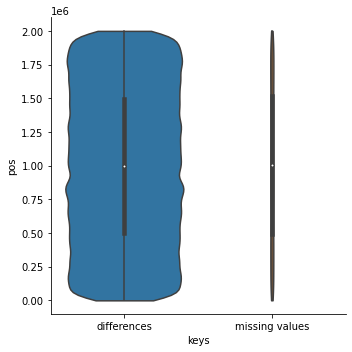

In [377]:
#S -14
gargaDir = "/home/mathieu/local/2e6/S14"
(totgargapos, totsimupos, difMatrix, errMatrix, nbsingGargaMean, 
nbsingSimuMean, nbdifMean,nberMean, fstMean) = statPostgarga(simuDir, gargaDir)

compute_sfs(gargaDir, 2e6, "S14")
sfspath = sumstatDir + "/S14.sfs"
ldpath = sumstatDir + "/S14.ld"
print_distribution(difMatrix, errMatrix)

In [378]:
y = 6
axs.flat[y*4].set(ylabel='S = -14')
plot_LD(ldpath,axs[y,0])
print_normalized_sfs(sfspath,axs[y,1])
print_sfs(sfspath,axs[y,2])
print_venn(totsimupos, totgargapos,axs[y][3])

fst : -0.04349522940581696
nbdif mean : 2598.75
nber mean : 0.3125
nbsing simu mean : 1739.34375
nbsing Garga mean : 2172.875


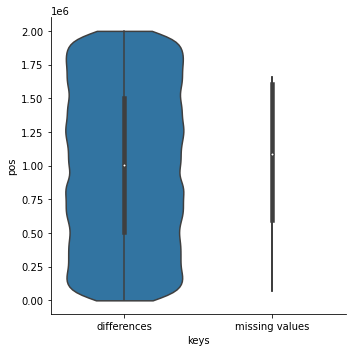

In [379]:
#deamination : neanderthal parameters
gargaDir = "/home/mathieu/local/2e6/nean"
(totgargapos, totsimupos, difMatrix, errMatrix, nbsingGargaMean, 
nbsingSimuMean, nbdifMean,nberMean, fstMean) = statPostgarga(simuDir, gargaDir)

compute_sfs(gargaDir, 2e6, "nean")
sfspath = sumstatDir + "/nean.sfs"
ldpath = sumstatDir + "/nean.ld"
print_distribution(difMatrix, errMatrix)

In [380]:
y = 7
axs.flat[y*4].set(ylabel='deamination')
plot_LD(ldpath,axs[y,0])
print_normalized_sfs(sfspath,axs[y,1])
print_sfs(sfspath,axs[y,2])
print_venn(totsimupos, totgargapos,axs[y][3])

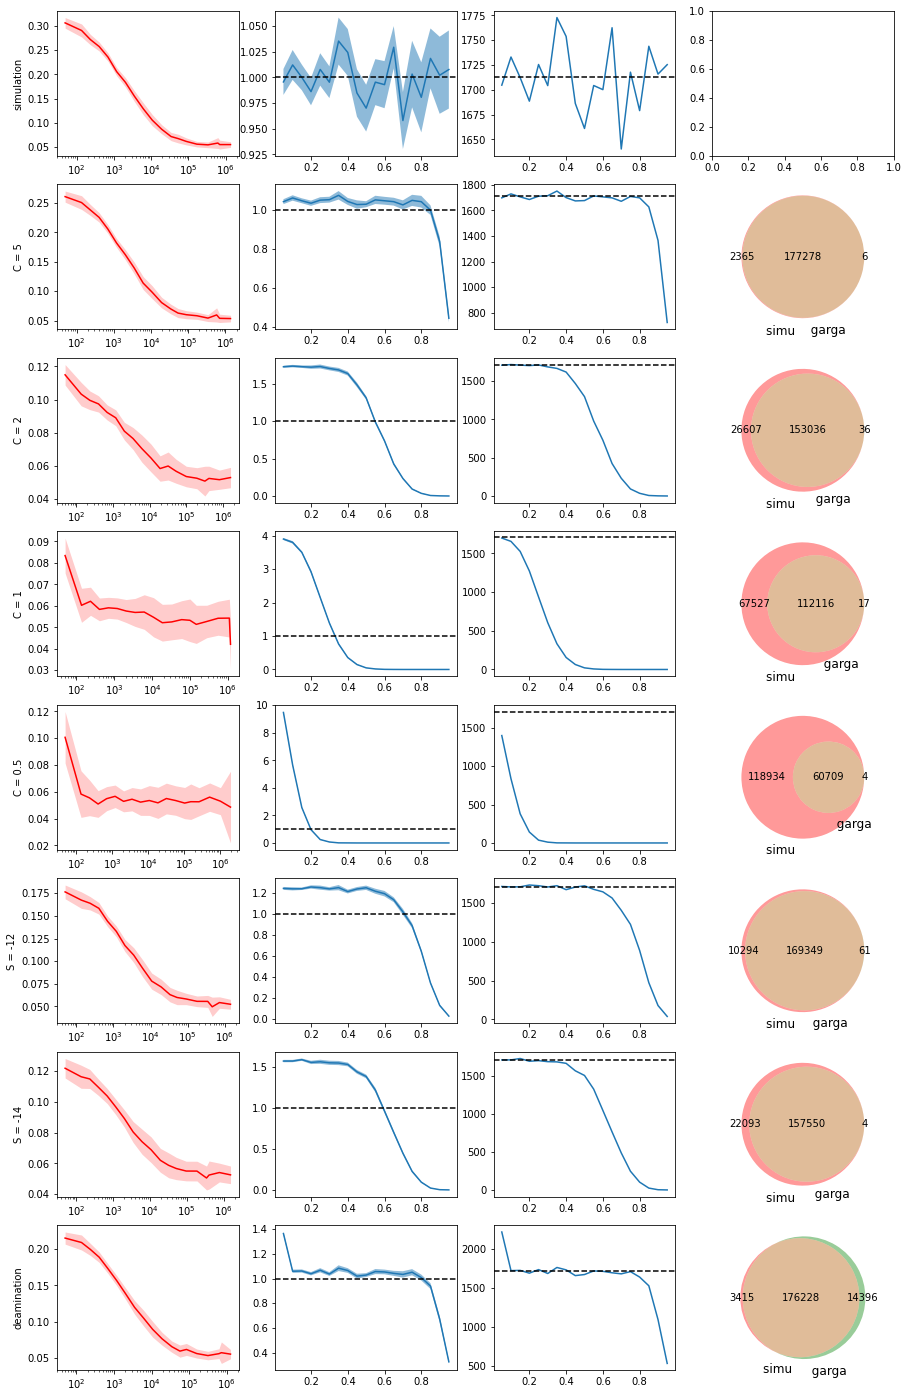

In [381]:
#Summary plot
fig.savefig('/home/mathieu/local/2e6/summary.png', transparent=False)
fig